In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x, tolerance=1e-10, max_iterations=1000):
    iter1 = 0
    for k in range(max_iterations):
        iter1 += 1   
        x_old  = x.copy()
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        if  max(abs((x - x_old)))/max(abs(x_old)) < tolerance:
            break
    #print("The L infinity norm in iteration", iter1,"is:", max(abs((x - x_old)))/max(abs(x_old)))       
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        #return np.linalg.solve(A, b)
        return gauss_seidel(A, b, -b)
        #return np.linalg.pinv(A).dot(b) 

### Burgers equation - conservative form

$
\frac{\displaystyle \partial u}{\displaystyle \partial t} + \frac{\displaystyle \partial}{\displaystyle \partial x}(\frac{\displaystyle u^2}{\displaystyle 2}) = \alpha \frac{\displaystyle \partial^2 u}{\displaystyle \partial x^2} + f 
$

#### Courant–Friedrichs–Lewy number

$
CFL = \frac{\displaystyle u \Delta t}{\displaystyle \Delta x}  \hspace{0.5cm} \text{one dimentional}\\
CFL \le 1
$

#### Von Neumann stability condition (for explicit)

$
r = \frac{\displaystyle \alpha \Delta t}{\displaystyle (\Delta x)^2} \\
r \le \frac{\displaystyle 1}{\displaystyle 2}
$



In [861]:
# (solve Au=f for each time step) 

class Burgers: 
    """
    Finite difference solution of the Burgers equation (nonloinear hyperbolic equation, for alpha=0)

    Parameters
    ----------
    alpha: float
        Diffusivity in m*m/s    
    dx: float
        Block size in meters
    N: int
        Number of blocks
    initial_condition: list (or numpy array) of floats
        Initial condition (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet', 'Neumann' or 'periodic'), e.g. ['Dirichlet','Neumann'] or ['periodic','periodic']  
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    time_integration: str | default 'implicit'
        Time integration (options: explict, implicit or Crank-Nicolson), e.g. 'implicit'
    space_discretization: str | default 'upwind'
        Space discretization (options: central or upwind), e.g. 'upwind'
    
    Methods
    -------
    forward(dt, source_term=None)
        Solve the transport equation for one time step of size dt considering the source term

    """  
    def __init__(self, alpha, dx, N, initial_condition, boundary_type = ['Dirichlet','Dirichlet'], boundary_values=[0, 0], time_integration='implicit', space_discretization='upwind'):   
        self.alpha = alpha
        self.dx = dx 
        self.N = N  
        self.u_previous = np.array(initial_condition) # For the first time step
        self.boundary_type = boundary_type
        self.boundary_values = boundary_values
        self.time_integration = time_integration 
        self.space_discretization = space_discretization
        self.timestep_count = 0
        if time_integration == 'implicit' or time_integration == 'Crank-Nicolson':
            self.A = np.empty((N,N))
            self.f = np.empty(N)
    
    # Solve the heat equation explicitly  
    def solve_explicit(self, dt, source_term):
        
        #Define w (upwind or central) advection space discretization
        if self.space_discretization == 'upwind':
            self.w = (self.u_previous>0)
        elif self.space_discretization == 'central':
            self.w = np.ones(len(self.u_previous))*0.5
        else:
            print(f'Space discretization {self.space_discretization} NOT available!')  
        
        # Define multiplicative constant for the conservative form. 
        c = dt/(self.dx*2)
    
        # Define r
        r = self.alpha*dt/(self.dx*self.dx)
        
        # initialize u and add source term
        u = self.u_previous + dt*source_term
        
        #----------
        # Calculate advection and diffusion terms for elements not in the boundary
        #
        ## Advective term
        for i in range(1,self.N-1): 
            u[i] += -c*((self.u_previous[i+1]**2-self.u_previous[i]**2)*(1-self.w[i])+(self.u_previous[i]**2-self.u_previous[i-1]**2)*self.w[i])  
        ## Diffusive term
        for i in range(1,self.N-1):  
            u[i] += r*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])              
        
        #----------      
        # Calculate advection and diffusion terms for elements in the boundaries 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            #
            ### Advective term 
            u[0] += -c*((self.u_previous[1]**2-self.u_previous[0]**2)*(1-self.w[0])+(self.u_previous[0]**2-self.boundary_values[0]**2)*self.w[0]) 
            ### Diffusive term
            u[0] += r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])             
        elif self.boundary_type[0] == 'Neumann':
            #
            ### Advective term 
            u[0] += -c*((self.u_previous[1]**2-self.u_previous[0]**2)*(1-self.w[0])+(self.u_previous[0]**2-(self.u_previous[0]-self.dx*self.boundary_values[0])**2)*self.w[0])   
            ### Diffusive term
            u[0] += r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1]) 
        elif self.boundary_type[0] == 'periodic':
            #
            ### Advective term 
            u[0] += -c*((self.u_previous[1]**2-self.u_previous[0]**2)*(1-self.w[0])+(self.u_previous[0]**2-self.u_previous[-1]**2)*self.w[0])    
            ### Diffusive term
            u[0] += r*(self.u_previous[-1]-2*self.u_previous[0]+self.u_previous[1]) 
        else:
            print('Left boundary: no condition satisfaed!')    
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            #
            ### Advective term 
            u[-1] += -c*((self.boundary_values[-1]**2-self.u_previous[-1]**2)*(1-self.w[-1])+(self.u_previous[-1]**2-self.u_previous[-2]**2)*self.w[-1])       
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1]) 
        elif self.boundary_type[1] == 'Neumann':
            #
            ### Advective term             
            u[-1] += -c*(((self.u_previous[-1]+self.dx*self.boundary_values[-1])**2-self.u_previous[-1]**2)*(1-self.w[-1])+(self.u_previous[-1]**2-self.u_previous[-2]**2)*self.w[-1])  
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])                 
        elif self.boundary_type[1] == 'periodic':
            #
            ### Advective term             
            u[-1] += -c*((self.u_previous[0]**2-self.u_previous[-1]**2)*(1-self.w[-1])+(self.u_previous[-1]**2-self.u_previous[-2]**2)*self.w[-1])    
            ### Diffusive term
            u[-1] += r*(self.u_previous[-2]-2*self.u_previous[-1]+self.u_previous[0])                 
        else:
            print('Left boundary: no condition satisfaed!')          
                       
        return u

    # Solve the heat equation fully implicit  
    def solve_implicit(self, dt, source_term):
        
        # u values to start the nonlinear iteration
        u_previous_nl = self.u_previous
        
        # Nonlinear loop (Picard)
        for j in range(20):
            
            #Define w (upwind or central) advection space discretization
            if self.space_discretization == 'upwind':
                self.w = (u_previous_nl>0)
            elif self.space_discretization == 'central':
                self.w = np.ones(len(u_previous_nl))*0.5
            else:
                print(f'Space discretization {self.space_discretization} NOT available!') 

            # Define multiplicative constant for the conservative form. 
            c = dt/(self.dx*2)

            # Define r
            r = self.alpha*dt/(self.dx*self.dx)

            #----------
            # (Au=f) Calculate matrix A and f 
            #
            ## matrix A
            self.A[:] = np.diag([1]*self.N, 0)  # Main diagonal (identity)
            #
            ### Advective term 
            self.A += np.diag(-c*u_previous_nl*(1-self.w)+c*u_previous_nl*self.w,  0)     # Main diagonal
            self.A += np.diag(c*u_previous_nl[1:]*(1-self.w[1:]), 1)                      # Upper diagonal
            self.A += np.diag(-c*u_previous_nl[:-1]*self.w[:-1],-1)                       # Lower diagonal       
            #
            ### Diffusive term
            self.A += np.diag([2*r]*self.N,  0)      # Main diagonal
            self.A += np.diag([-r]*(self.N-1), 1)    # Upper diagonal
            self.A += np.diag([-r]*(self.N-1),-1)    # Lower diagonal  
            #
            ## Source term f
            self.f[:] = self.u_previous + dt*source_term    


            # ----------
            # Calculate boundary conditions 
            #
            ## Left boundary
            if self.boundary_type[0] == 'Dirichlet':
                #
                ### Advective term             
                self.f[0] += (self.boundary_values[0]**2)*self.w[0]*c  
                ### Diffusive term      
                self.f[0] += self.boundary_values[0]*r 
            elif self.boundary_type[0] == 'Neumann':
                #
                ### Advective term               
                self.f[0]  += ((self.boundary_values[0]*self.dx)**2)*self.w[0]*c    
                self.A[0,0] += -c*u_previous_nl[0]*self.w[0]+2*c*u_previous_nl[0]*self.boundary_values[0]*self.dx*self.w[0]
                ### Diffusive term      
                self.f[0]  += -self.boundary_values[0]*r*self.dx   
                self.A[0,0] += -r                
            elif self.boundary_type[0] == 'periodic':
                #
                ### Advective term               
                self.A[0,-1] += -c*u_previous_nl[0]*self.w[0]  
                ### Diffusive term     
                self.A[0,-1] += -r                
            else:
                print('Left boundary: no condition satisfaed!')
            #
            ## Right boundary
            if self.boundary_type[1] == 'Dirichlet':
                #
                ### Advective term              
                self.f[-1] += -(self.boundary_values[-1]**2)*(1-self.w[-1])*c 
                ### Diffusive term     
                self.f[-1] += self.boundary_values[-1]*r
            elif self.boundary_type[1] == 'Neumann':
                #
                ### Advective term              
                self.f[-1] += -((self.boundary_values[-1]*self.dx)**2)*(1-self.w[-1])*c 
                self.A[-1,-1] += c*u_previous_nl[-1]*(1-self.w[-1])+2*c*u_previous_nl[-1]*self.boundary_values[-1]*self.dx*(1-self.w[-1])
                ### Diffusive term     
                self.f[-1] += self.boundary_values[-1]*r*self.dx  
                self.A[-1,-1] += -r            
            elif self.boundary_type[1] == 'periodic':
                #
                ### Advective term              
                self.A[-1,0] += c*u_previous_nl[-1]*(1-self.w[-1])
                ### Diffusive term     
                self.A[-1,0] += -r
            else:
                print('Right boundary: no condition satisfaed!')         

            # Calculate u from Au=f
            u = solve_linear(self.A, self.f)
            error = max(abs((u-u_previous_nl)/(u_previous_nl+1e-6)))
            print(f'Nonlinear iteration {j} error: {error}')
            if error < 0.001:
                break
            
            # u values from the last nonlinear iteration
            u_previous_nl = u
    
        return u
    
    # Solve the heat equation using Crank-Nicolson (theta = 0 -> explicit, 1-> implicit)
    def solve_CrankNicolson(self, dt, source_term, theta=0.5):
        
        # u values to start the nonlinear iteration
        u_previous_nl = self.u_previous
        
        # Nonlinear loop (Picard)
        for j in range(10):
        
            #Define w (upwind or central) advection space discretization
            if self.space_discretization == 'upwind':
                self.w = (u_previous_nl>0)
            elif self.space_discretization == 'central':
                self.w = np.ones(len(u_previous_nl))*0.5
            else:
                print(f'Space discretization {self.space_discretization} NOT available!') 

            # Define multiplicative constant for the conservative form. 
            c = dt/(self.dx*2)

            # Define r
            r = self.alpha*dt/(self.dx*self.dx)        

            #----------
            # (Au=f) Calculate matrix A and f 
            #
            ## matrix A
            self.A[:] = np.diag([1]*self.N, 0)  # Main diagonal (identity)
            #
            ### Advective term         
            self.A += np.diag(-theta*c*u_previous_nl*(1-self.w)+theta*c*u_previous_nl*self.w,  0)     # Main diagonal
            self.A += np.diag(theta*c*u_previous_nl[1:]*(1-self.w[1:]), 1)                            # Upper diagonal
            self.A += np.diag(-theta*c*u_previous_nl[:-1]*self.w[:-1],-1)                             # Lower diagonal   
            #
            ### Diffusive term       
            self.A += np.diag([2*r*theta]*self.N,  0)  # Main diagonal
            self.A += np.diag([-r*theta]*(self.N-1), 1)    # Upper diagonal
            self.A += np.diag([-r*theta]*(self.N-1),-1)    # Lower diagonal          
            #
            #
            ## Source term f
            self.f[:] = self.u_previous + dt*source_term
            ### Advective term    
            for i in range(1,self.N-1):
                self.f[i] += -(1-theta)*c*((self.u_previous[i+1]**2-self.u_previous[i]**2)*(1-self.w[i])+(self.u_previous[i]**2-self.u_previous[i-1]**2)*self.w[i])  
            ### Diffusive term       
            for i in range(1,self.N-1):
                self.f[i] += r*(1-theta)*(self.u_previous[i-1]-2*self.u_previous[i]+self.u_previous[i+1])        

            #----------
            # Calculate boundary conditions 
            #
            ## Left boundary
            if self.boundary_type[0] == 'Dirichlet':
                #
                ### Advective term               
                self.f[0] += -(1-theta)*c*((self.u_previous[1]**2-self.u_previous[0]**2)*(1-self.w[0])+(self.u_previous[0]**2-self.boundary_values[0]**2)*self.w[0]) 
                self.f[0] += theta*(self.boundary_values[0]**2)*self.w[0]*c  
                ### Diffusive term         
                self.f[0] += (1-theta)*r*(self.boundary_values[0]-2*self.u_previous[0]+self.u_previous[1])
                self.f[0] += theta*r*self.boundary_values[0]            
            elif self.boundary_type[0] == 'Neumann':
                #
                ### Advective term               
                self.f[0] += -(1-theta)*c*((self.u_previous[1]**2-self.u_previous[0]**2)*(1-self.w[0])+(self.u_previous[0]**2-(self.u_previous[0]-self.dx*self.boundary_values[0])**2)*self.w[0])   
                self.f[0] += -theta*((self.boundary_values[0]*self.dx)**2)*self.w[0]*c
                self.A[0,0] += -theta*c*u_previous_nl[0]*self.w[0]+2*c*u_previous_nl[0]*self.boundary_values[0]*self.dx*self.w[0]
                ### Diffusive term        
                self.f[0] += (1-theta)*r*(-self.dx*self.boundary_values[0]-self.u_previous[0]+self.u_previous[1])
                self.f[0] += -theta*self.dx*r*self.boundary_values[0]     
                self.A[0,0] += -r*theta
            elif self.boundary_type[0] == 'periodic':
                #
                ### Advective term               
                self.f[0] += -(1-theta)*c*((self.u_previous[1]**2-self.u_previous[0]**2)*(1-self.w[0])+(self.u_previous[0]**2-self.u_previous[-1]**2)*self.w[0])    
                self.A[0,-1] += -theta*c*u_previous_nl[0]*self.w[0]  
                ### Diffusive term   
                f[0] += (1-theta)*r*(self.u_previous[-1]-2*self.u_previous[0]+self.u_previous[1]) 
                self.A[0,-1] += -theta*r 
            else:
                print('Left boundary: no condition satisfaed!')
            #
            ## Right boundary
            if self.boundary_type[1] == 'Dirichlet':
                #
                ### Advective term              
                self.f[-1] += -(1-theta)*c*((self.boundary_values[-1]**2-self.u_previous[-1]**2)*(1-self.w[-1])+(self.u_previous[-1]**2-self.u_previous[-2]**2)*self.w[-1])       
                self.f[-1] += -theta*(self.boundary_values[-1]**2)*(1-self.w[-1])*c   
                ### Diffusive term   
                self.f[-1] += (1-theta)*r*(self.u_previous[-2]-2*self.u_previous[-1]+self.boundary_values[-1])
                self.f[-1] += theta*r*self.boundary_values[-1]            
            elif self.boundary_type[1] == 'Neumann':
                #
                ### Advective term              
                self.f[-1] += -(1-theta)*c*(((self.u_previous[-1]+self.dx*self.boundary_values[-1])**2-self.u_previous[-1]**2)*(1-self.w[-1])+(self.u_previous[-1]**2-self.u_previous[-2]**2)*self.w[-1])  
                self.f[-1] += -theta*((self.boundary_values[-1]*self.dx)**2)*(1-self.w[-1])*c  
                self.A[-1,-1] += theta*c*u_previous_nl[-1]*(1-self.w[-1])+2*c*u_previous_nl[-1]*self.boundary_values[-1]*self.dx*(1-self.w[-1])
                ### Diffusive term   
                self.f[-1] += (1-theta)*r*(self.u_previous[-2]-self.u_previous[-1]+self.dx*self.boundary_values[-1])
                self.f[-1] += self.dx*r*theta*self.boundary_values[-1] 
                self.A[-1,-1] += -r*theta            
            elif self.boundary_type[1] == 'periodic':
                #
                ### Advective term              
                self.f[-1] += -(1-theta)*c*((self.u_previous[0]**2-self.u_previous[-1]**2)*(1-self.w[-1])+(self.u_previous[-1]**2-self.u_previous[-2]**2)*self.w[-1])                   
                self.A[-1,0] += theta*c*u_previous_nl[-1]*(1-self.w[-1])
                ### Diffusive term   
                self.f[-1] += (1-theta)*r*(self.u_previous[-2]-2*self.u_previous[-1]+self.u_previous[0])
                self.A[-1,0] += -theta*r            
            else:
                print('Right boundary: no condition satisfaed!')

            # Calculate u from Au=f
            u = solve_linear(self.A, self.f)
            error = max(abs((u-u_previous_nl)/(u_previous_nl+1e-6)))
            print(f'Nonlinear iteration {j} error: {error}')
            if error < 0.001:
                break
            
            # u values from the last nonlinear iteration
            u_previous_nl = u
        
        return u 
    
            
    def forward(self, dt, source_term=None):
        """
        Solve the advection/convection-diffusion equation for one time step of size dt considering the source term
        
        
        Parameters
        ----------
        dt: float
            Time step size in seconds
        source_term: list (or numpy array) of floats | default None
            Source term (one value per block -> size N)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field after time step dt (one value per block -> size N)

        """          
        source_term = np.array(self.N*[0]) if source_term == None else np.array(source_term)
        
        if self.time_integration == 'implicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {max(self.u_previous)*dt/self.dx:.2f}, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_implicit(dt, source_term)
            self.u_previous[:] = u
            
        elif self.time_integration == 'Crank-Nicolson':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {max(self.u_previous)*dt/self.dx:.2f}, r = {self.alpha*dt/(self.dx*self.dx):.2f}, total time = {self.timestep_count*dt}s')
          
            u = self.solve_CrankNicolson(dt, source_term, theta=0.5)
            self.u_previous[:] = u            
        
        elif self.time_integration == 'explicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {max(self.u_previous)*dt/self.dx:.2f}{"(***WARNING cfl>1)" if max(self.u_previous)*dt/self.dx > 1.0 else ""}, r = {self.alpha*dt/(self.dx*self.dx):.2f}{"(***WARNING r>=1/2)" if self.alpha*dt/(self.dx*self.dx) >= 0.5 else ""}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_explicit(dt, source_term)
            self.u_previous[:] = u
            
        else:
            print(f'Time integration {self.time_integration} NOT available!')
            return None
        
        return u

### Solve implicit

In [870]:
burgers = Burgers(alpha=0.0,
            dx=1.0,
            N=150, 
            initial_condition = list(np.sin(np.linspace(0,(4/2)*np.pi,150,endpoint=False))+0.5), #50*[10.]+50*[0.]+50*[0.], 
            #boundary_type = ['Dirichlet','Neumann'],
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='implicit',
            space_discretization='upwind')

In [871]:
# Initialize u
u=[]
u.append(burgers.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 0.5s
Nonlinear iteration 0 error: 0.03378247870295523
Nonlinear iteration 1 error: 0.0021194622808788136
Nonlinear iteration 2 error: 0.0002488476694529347
Time step 2 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 1.0s
Nonlinear iteration 0 error: 0.03431040324737118
Nonlinear iteration 1 error: 0.0016753436479356929
Nonlinear iteration 2 error: 0.00019456251672835215
Time step 3 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 1.5s
Nonlinear iteration 0 error: 0.034866107982744324
Nonlinear iteration 1 error: 0.0013274250902700197
Nonlinear iteration 2 error: 0.00015280896967622044
Time step 4 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 2.0s
Nonlinear iteration 0 error: 0.035451733875076524
Nonlinear iteration 1 error: 0.0010537391200992592
Nonlinear iteration 2 error: 0.00012045080351836933
Time step 5 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 2.5s
Nonlinear iteration 0 error: 0.03606965545701691
Nonlinear it

Nonlinear iteration 3 error: 0.0003701778482074105
Time step 44 => dt = 0.5s, cfl = 0.73, r = 0.00, total time = 22.0s
Nonlinear iteration 0 error: 0.7530426851008343
Nonlinear iteration 1 error: 0.06557603491284225
Nonlinear iteration 2 error: 0.0016292900184927078
Nonlinear iteration 3 error: 0.00027485346664673957
Time step 45 => dt = 0.5s, cfl = 0.73, r = 0.00, total time = 22.5s
Nonlinear iteration 0 error: 0.5277436443324399
Nonlinear iteration 1 error: 0.042855140240659985
Nonlinear iteration 2 error: 0.0010679644209611316
Nonlinear iteration 3 error: 0.00017993997993893225
Time step 46 => dt = 0.5s, cfl = 0.73, r = 0.00, total time = 23.0s
Nonlinear iteration 0 error: 0.412932443041947
Nonlinear iteration 1 error: 0.027841011112408758
Nonlinear iteration 2 error: 0.0012836757266410153
Nonlinear iteration 3 error: 0.00011558906578178043
Time step 47 => dt = 0.5s, cfl = 0.73, r = 0.00, total time = 23.5s
Nonlinear iteration 0 error: 0.3370187694341206
Nonlinear iteration 1 error:

Nonlinear iteration 1 error: 0.10017981723237926
Nonlinear iteration 2 error: 0.01585785918395178
Nonlinear iteration 3 error: 0.0018751263143513175
Nonlinear iteration 4 error: 0.00020829792099496652
Time step 73 => dt = 0.5s, cfl = 0.72, r = 0.00, total time = 36.5s
Nonlinear iteration 0 error: 0.3629579720685047
Nonlinear iteration 1 error: 0.19781699094279678
Nonlinear iteration 2 error: 0.04087628691711119
Nonlinear iteration 3 error: 0.006190520673400825
Nonlinear iteration 4 error: 0.0008697977010131988
Time step 74 => dt = 0.5s, cfl = 0.71, r = 0.00, total time = 37.0s
Nonlinear iteration 0 error: 1.0946489732372955
Nonlinear iteration 1 error: 2.70825603735617
Nonlinear iteration 2 error: 0.13825396706216658
Nonlinear iteration 3 error: 0.02880913661846565
Nonlinear iteration 4 error: 0.004794553951582711
Nonlinear iteration 5 error: 0.0007488680004598221
Time step 75 => dt = 0.5s, cfl = 0.71, r = 0.00, total time = 37.5s
Nonlinear iteration 0 error: 4.84272214804352
Nonlinear

Nonlinear iteration 2 error: 0.20355968815332834
Nonlinear iteration 3 error: 0.041049703946747056
Nonlinear iteration 4 error: 0.0055939443482539795
Nonlinear iteration 5 error: 0.0005904542347557434
Time step 100 => dt = 0.5s, cfl = 0.69, r = 0.00, total time = 50.0s
Nonlinear iteration 0 error: 7.68740180374537
Nonlinear iteration 1 error: 0.059561689084258705
Nonlinear iteration 2 error: 0.019936795831699758
Nonlinear iteration 3 error: 0.005064506895812694
Nonlinear iteration 4 error: 0.001096457780501553
Nonlinear iteration 5 error: 0.0002166543066730029
3.117565155029297


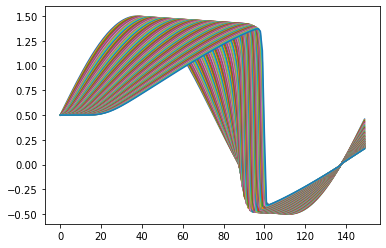

In [872]:
start = time.time()
for _ in range(100):
    u.append(burgers.forward(dt=0.5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_imp = u




Determinant = 2476393017.8986325
Error =  1.1322678905578698e-12


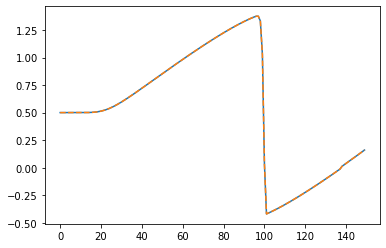

In [873]:
#print('A = \n', burgers.A)
print()
#print('u = \n', u[-1])
print()
#print('f = \n', burgers.f)
print()
print('Determinant =', np.linalg.det(burgers.A))
print('Error = ', np.max(abs(burgers.A.dot(u[-1])-burgers.f)))

plt.plot(burgers.A.dot(u[-1]))
plt.plot(burgers.f, '--')

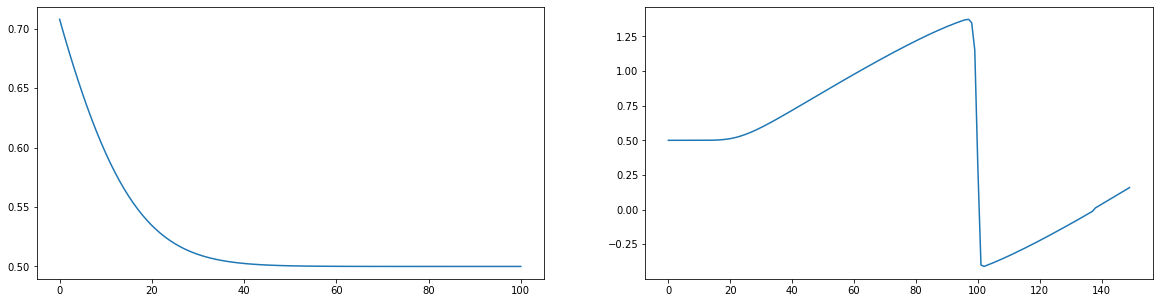

In [874]:
#print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_imp)[:,5])
axes[1].plot(u_imp[-1])

### Solve explicit

In [875]:
burgers = Burgers(alpha=0.0,
            dx=1.0,
            N=150, 
            initial_condition = list(np.sin(np.linspace(0,(4/2)*np.pi,150,endpoint=False))+0.5), #50*[10.]+50*[0.]+50*[0.], 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='explicit',
            space_discretization='upwind')

In [876]:
# Initialize u
u=[]
u.append(burgers.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 0.5s
Time step 2 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 1.0s
Time step 3 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 1.5s
Time step 4 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 2.0s
Time step 5 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 2.5s
Time step 6 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 3.0s
Time step 7 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 3.5s
Time step 8 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 4.0s
Time step 9 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 4.5s
Time step 10 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 5.0s
Time step 11 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 5.5s
Time step 12 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 6.0s
Time step 13 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 6.5s
Time step 14 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 7.0s
Time step 15 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 7.5s
Time

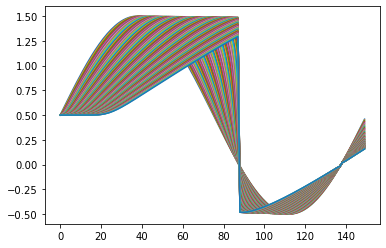

In [877]:
start = time.time()
for _ in range(100):
    u.append(burgers.forward(dt=0.5, # seconds
                               #source_term=4*[0.]+3*[0.]+4*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_exp = u

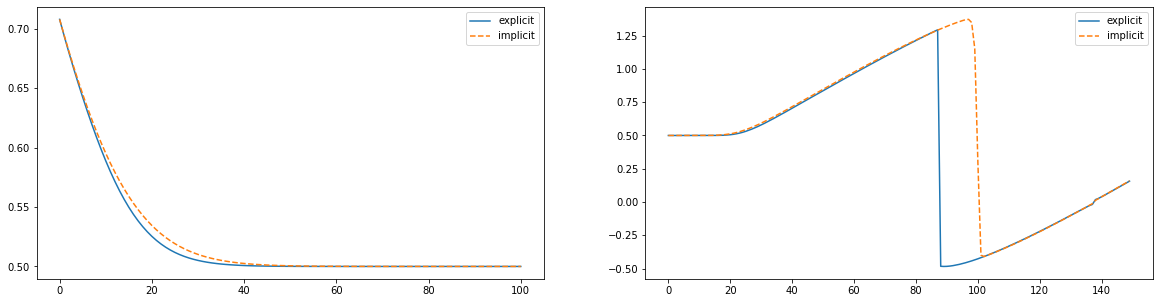

In [878]:
#print(u_exp[-1])
#print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].legend(['explicit','implicit'])
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].legend(['explicit','implicit'])

### Solve Crank-Nicolson

In [884]:
burgers = Burgers(alpha=0.0,
            dx=1.0,
            N=150, 
            initial_condition = list(np.sin(np.linspace(0,(4/2)*np.pi,150,endpoint=False))+0.5), #50*[10.]+50*[0.]+50*[0.], 
            #boundary_type = ['Dirichlet','Neumann'],
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='Crank-Nicolson',
            space_discretization='upwind')

In [885]:
# Initialize u
u=[]
u.append(burgers.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 0.5s
Nonlinear iteration 0 error: 0.03559394319512885
Nonlinear iteration 1 error: 0.0011973465559810353
Nonlinear iteration 2 error: 7.460846913738911e-05
Time step 2 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 1.0s
Nonlinear iteration 0 error: 0.03605151876736227
Nonlinear iteration 1 error: 0.0009156144648921481
Time step 3 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 1.5s
Nonlinear iteration 0 error: 0.0365341051815158
Nonlinear iteration 1 error: 0.0007037345943035078
Time step 4 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 2.0s
Nonlinear iteration 0 error: 0.03704343964964965
Nonlinear iteration 1 error: 0.0005424621181405119
Time step 5 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 2.5s
Nonlinear iteration 0 error: 0.037581378613392766
Nonlinear iteration 1 error: 0.0004953472622144807
Time step 6 => dt = 0.5s, cfl = 0.75, r = 0.00, total time = 3.0s
Nonlinear iteration 0 error: 0.03814997261831932
Nonl

Nonlinear iteration 2 error: 0.005967962824869611
Nonlinear iteration 3 error: 0.0003054910675537183
Time step 46 => dt = 0.5s, cfl = 0.74, r = 0.00, total time = 23.0s
Nonlinear iteration 0 error: 1.2399660927659102
Nonlinear iteration 1 error: 8.662003888529387
Nonlinear iteration 2 error: 0.0031903171758422845
Nonlinear iteration 3 error: 3.75658433277037e-05
Time step 47 => dt = 0.5s, cfl = 0.74, r = 0.00, total time = 23.5s
Nonlinear iteration 0 error: 1.779944120703485
Nonlinear iteration 1 error: 0.04245304909791139
Nonlinear iteration 2 error: 0.0002672085332889471
Time step 48 => dt = 0.5s, cfl = 0.74, r = 0.00, total time = 24.0s
Nonlinear iteration 0 error: 0.7780638483794496
Nonlinear iteration 1 error: 0.019951476989208846
Nonlinear iteration 2 error: 0.0003361572674091113
Time step 49 => dt = 0.5s, cfl = 0.74, r = 0.00, total time = 24.5s
Nonlinear iteration 0 error: 0.5071149485692668
Nonlinear iteration 1 error: 0.027573150563759186
Nonlinear iteration 2 error: 0.000281

Nonlinear iteration 4 error: 0.0003943411212128943
Time step 79 => dt = 0.5s, cfl = 0.73, r = 0.00, total time = 39.5s
Nonlinear iteration 0 error: 1.1878019457466658
Nonlinear iteration 1 error: 0.07357004141290044
Nonlinear iteration 2 error: 0.008763074721629
Nonlinear iteration 3 error: 0.0009184173590066821
Time step 80 => dt = 0.5s, cfl = 0.72, r = 0.00, total time = 40.0s
Nonlinear iteration 0 error: 0.4458805313784284
Nonlinear iteration 1 error: 0.10104587716180301
Nonlinear iteration 2 error: 0.01497810264765657
Nonlinear iteration 3 error: 0.0019454237980912835
Nonlinear iteration 4 error: 0.0002556909375668031
Time step 81 => dt = 0.5s, cfl = 0.72, r = 0.00, total time = 40.5s
Nonlinear iteration 0 error: 0.3926339430584452
Nonlinear iteration 1 error: 0.14195969814547524
Nonlinear iteration 2 error: 0.02337156577020667
Nonlinear iteration 3 error: 0.003181060843538314
Nonlinear iteration 4 error: 0.0004452524285955532
Time step 82 => dt = 0.5s, cfl = 0.72, r = 0.00, total 

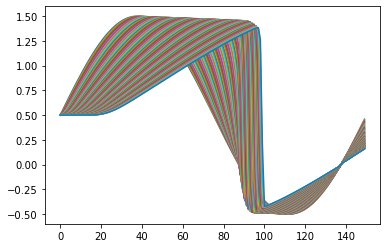

In [886]:
start = time.time()
for _ in range(100):
    u.append(burgers.forward(dt=0.5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_cn = u




Determinant = 74557.99006460504
Error =  7.393252676735074e-13


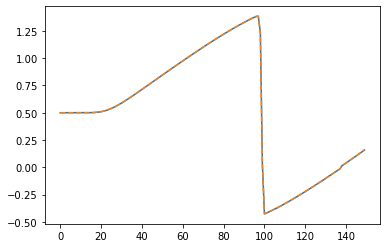

In [887]:
#print('A = \n', transport.A)
print()
#print('u = \n', u[-1])
print()
#print('f = \n', transport.f)
print()
print('Determinant =', np.linalg.det(burgers.A))
print('Error = ', np.max(abs(burgers.A.dot(u[-1])-burgers.f)))

plt.plot(burgers.A.dot(u[-1]))
plt.plot(burgers.f, '--')

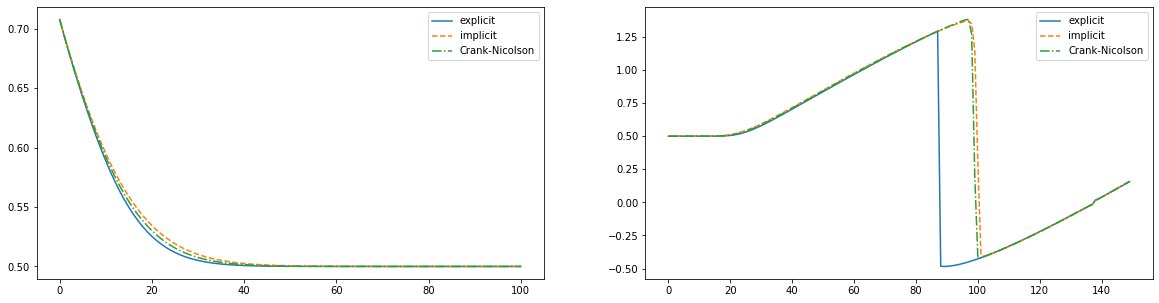

In [888]:
#print(u_exp[-1])
#print(u_imp[-1])
#print(u_cn[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].plot(np.array(u_cn)[:,5],'-.')
axes[0].legend(['explicit','implicit','Crank-Nicolson'])
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].plot(u_cn[-1],'-.')
axes[1].legend(['explicit','implicit','Crank-Nicolson'])